# Use Perception Hashing to find Similar Images

In [1]:
import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt
from imagehash import phash, average_hash, whash
from pathlib import Path
from PIL import Image
from scipy.spatial.distance import pdist, squareform

In [2]:
img_path = Path('../data/images')
plt_path = Path('../plots')

plt_path.mkdir(exist_ok=True)

In [3]:
# show images

s_images = (pd.Series(img_path.glob('unsplash/**/*.jpg'))
            .sort_values()
            .rename('path')
           )
s_images.index = s_images.map(lambda p: p.name.split('.')[0]).rename('image_id')
display(s_images.head())

image_id
4s2FBznYIxg    ../data/images/unsplash/yoga/4s2FBznYIxg.jpg
CDJCAcAAPlU    ../data/images/unsplash/yoga/CDJCAcAAPlU.jpg
I7FsT6N94io    ../data/images/unsplash/yoga/I7FsT6N94io.jpg
L5o5ainVP_I    ../data/images/unsplash/yoga/L5o5ainVP_I.jpg
N6FsJrlk89U    ../data/images/unsplash/yoga/N6FsJrlk89U.jpg
Name: path, dtype: object

In [4]:
def plot_img(img_paths: pd.Series, ncol:int = 4):
    nrow = int(len(img_paths) / ncol) + (1 if len(img_paths) % ncol != 0 else 0)

    fig, axs = plt.subplots(nrow, ncol, figsize=(12,8))
    axs = axs.flatten()[:len(img_paths)]

    for (img, path), ax in zip(img_paths.iteritems(), axs):
        ax.imshow(plt.imread(str(path)))
        ax.set_title(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig.tight_layout()
    return fig

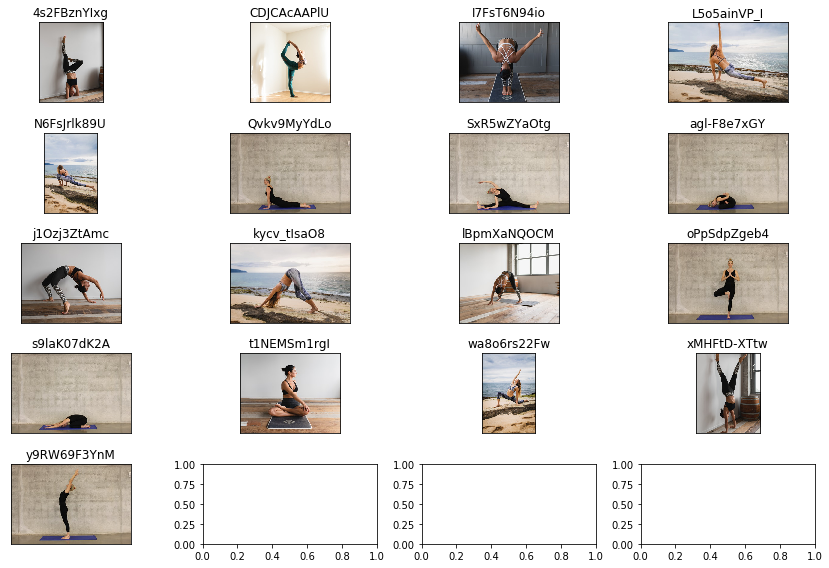

In [5]:
plt.show(plot_img(s_images))

## file hash

In [6]:
def hashfile(filepath, blocksize=65536):
    hasher = hashlib.md5()
    with open(filepath, 'rb') as afile:
        buf = afile.read(blocksize)
        while len(buf) > 0:
            hasher.update(buf)
            buf = afile.read(blocksize)
    return hasher.hexdigest()

In [7]:
for i in sorted(s_images):
    print(hashfile(i), i)

774b7a825faf87d9755a2dcc3f6f7aac ../data/images/unsplash/yoga/4s2FBznYIxg.jpg
e7b954dadb0ddb7ef0924247643d715c ../data/images/unsplash/yoga/CDJCAcAAPlU.jpg
0872c3867b1b858ff5dc882a4bb9857b ../data/images/unsplash/yoga/I7FsT6N94io.jpg
88e003a7ed22aac37c48b12f494ef6b7 ../data/images/unsplash/yoga/L5o5ainVP_I.jpg
8f2b1b8eb9037ce85ca6642cdc9f7ccb ../data/images/unsplash/yoga/N6FsJrlk89U.jpg
4c2334dd5c960129080e44baf581c2cf ../data/images/unsplash/yoga/Qvkv9MyYdLo.jpg
1414db1c0d9ed5998f54bfe9c2437d2d ../data/images/unsplash/yoga/SxR5wZYaOtg.jpg
f85d30461ee6461adf45e862bd09efdd ../data/images/unsplash/yoga/agl-F8e7xGY.jpg
b0ad3f7031809aec2e01ed2ddc85a58c ../data/images/unsplash/yoga/j1Ozj3ZtAmc.jpg
f9b78501b9f80dbae8839208267b11bd ../data/images/unsplash/yoga/kycv_tIsaO8.jpg
04d3e81e772556d1fc5258e76907edcc ../data/images/unsplash/yoga/lBpmXaNQOCM.jpg
7eb5309db665329a492a06c4033a2b97 ../data/images/unsplash/yoga/oPpSdpZgeb4.jpg
8fa4d15fecfa3ded542cf5e0ba39dcc4 ../data/images/unsplash/yoga/s9

## Load images

In [8]:
def load_images(img_paths: pd.Series) -> pd.Series:
    return img_paths.map(Image.open).rename('image')

In [9]:
images = load_images(s_images)
images.head()

image_id
4s2FBznYIxg    <PIL.JpegImagePlugin.JpegImageFile image mode=...
CDJCAcAAPlU    <PIL.JpegImagePlugin.JpegImageFile image mode=...
I7FsT6N94io    <PIL.JpegImagePlugin.JpegImageFile image mode=...
L5o5ainVP_I    <PIL.JpegImagePlugin.JpegImageFile image mode=...
N6FsJrlk89U    <PIL.JpegImagePlugin.JpegImageFile image mode=...
Name: image, dtype: object

## Compute Perceptual Hashes

In [10]:
# define hash functions
hash_funs = [average_hash, phash, whash]

In [11]:
def hash_images(images: pd.Series, hash) -> pd.Series:
    """Hashed a series of images with the given hash function."""
    return images.map(hash).rename(hash.__name__)

In [12]:
# apply all hash functions on all images
df_hash = pd.concat([hash_images(images, hash) for hash in hash_funs], axis=1)
df_hash.head()

,average_hash,phash,whash
image_id,,,
4s2FBznYIxg,feffdfcfc6c4c080,f18d4e76255a9964,f2ffdfc7c6848000
CDJCAcAAPlU,ffe7e7e3e365e0e0,e289d98664d99b66,7fe3e3636161e0c0
I7FsT6N94io,fefef4700000c0c3,e2defd130148b25e,fefff6700020c0c7
L5o5ainVP_I,ffffffef06808000,f1936c1f42b94c33,feffefcf04e00000
N6FsJrlk89U,ffffff5f02030010,fc9547369822bd43,ffffff5f04020000


## Assess Performance of all Hash Functions

In [13]:
from timeit import timeit

def wrapper(func, *args):
    """Decorator for hash function with arguments."""
    def wrapped():
        return func(*args)
    return wrapped

In [14]:
print('>>Timing')
for hash in hash_funs:
    elapsed = timeit(wrapper(hash_images, images, hash), number=20)
    print(f'{elapsed} ({hash.__name__})')

>>Timing
0.37224401894491166 (average_hash)
0.5506796350236982 (phash)
2.620467977016233 (whash)


## Compute Hamming Distance between Hashes

In [15]:
def hash_dist(s_hashes: pd.Series) -> pd.DataFrame:
    """Computes Hamming distance between all pairs of given hashes."""
    # 8 byte -> 64 bool
    s_binary = s_hashes.map(lambda x: x.hash.flatten())
    
    #  compute distances and reshape to square form
    dists = pdist(np.vstack(s_binary), metric='hamming')
    
    return pd.DataFrame(squareform(dists), index=s_hashes.index)

In [16]:
(hash_dist(df_hash.phash) * 64).astype(int)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
image_id,,,,,,,,,,,,,,,,,
4s2FBznYIxg,0,20,28,30,24,34,28,28,32,42,24,24,26,30,28,32,24
CDJCAcAAPlU,20,0,24,30,34,30,28,22,26,32,32,24,28,34,28,30,30
I7FsT6N94io,28,24,0,32,32,34,32,32,32,28,28,24,30,36,32,26,26
L5o5ainVP_I,30,30,32,0,30,20,24,28,36,30,32,28,32,20,34,36,30
N6FsJrlk89U,24,34,32,30,0,36,32,30,24,44,32,30,26,26,30,36,30
Qvkv9MyYdLo,34,30,34,20,36,0,16,16,30,24,32,28,30,32,32,42,30
SxR5wZYaOtg,28,28,32,24,32,16,0,12,32,30,30,28,20,30,38,34,20
agl-F8e7xGY,28,22,32,28,30,16,12,0,28,32,36,24,20,34,38,32,22
j1Ozj3ZtAmc,32,26,32,36,24,30,32,28,0,34,36,40,28,36,34,36,38


## Compute all similarities

In [17]:
def plot_sims(df, title=None, figsize=(12,12)):
    num = df.shape[0]

    fig, axs = plt.subplots(num, num, figsize=figsize)

    # iterate over each image
    for i, name in enumerate(df.index):
        sorted = df[i].sort_values(ascending=False)

        for j, (img, score) in enumerate(sorted.iteritems()):
            axs[i,j].imshow(plt.imread(str(df_sims.path.loc[img])))
            if j == 0:
                axs[i,j].set_title(name, size=7)
            else:
                axs[i,j].set_title(f'{score*100:.1f}%', size=7)
            axs[i,j].axis('off')
    fig.suptitle(title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

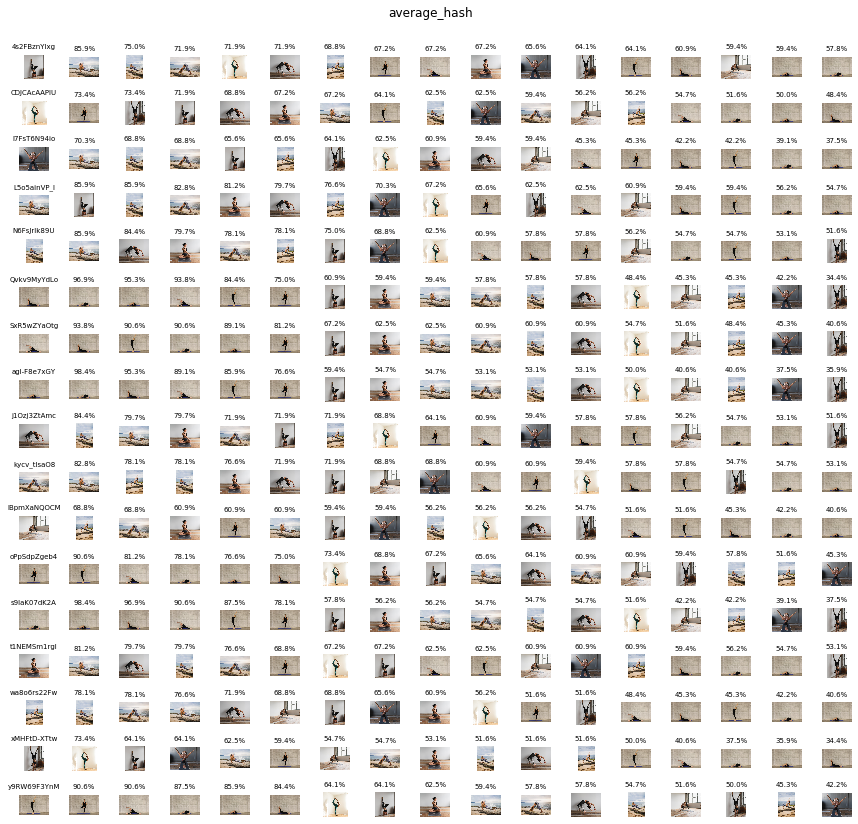

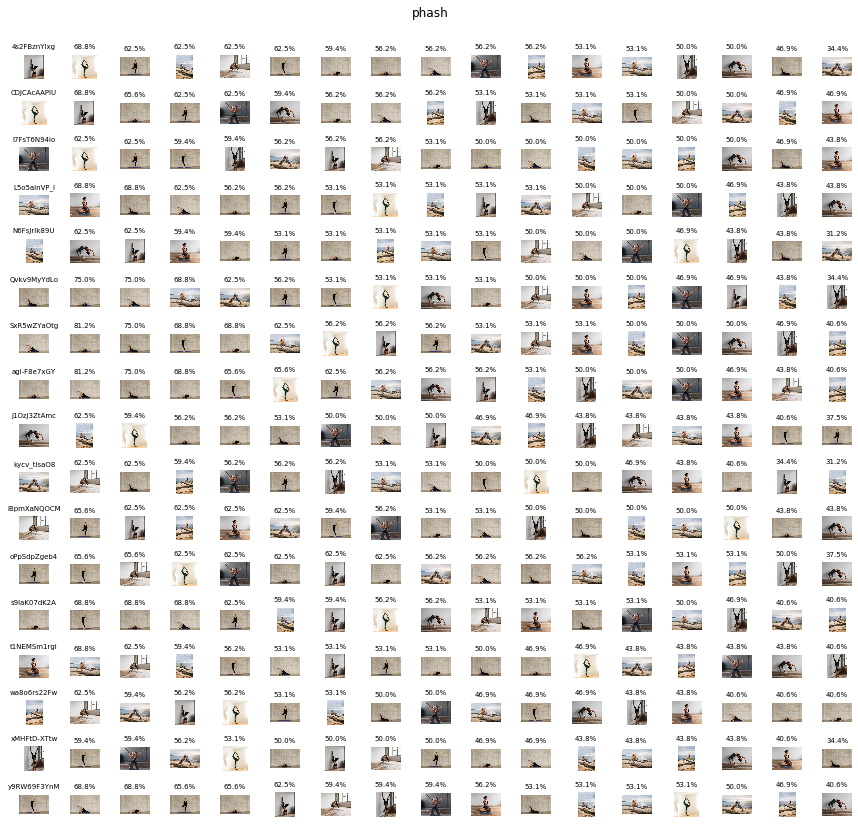

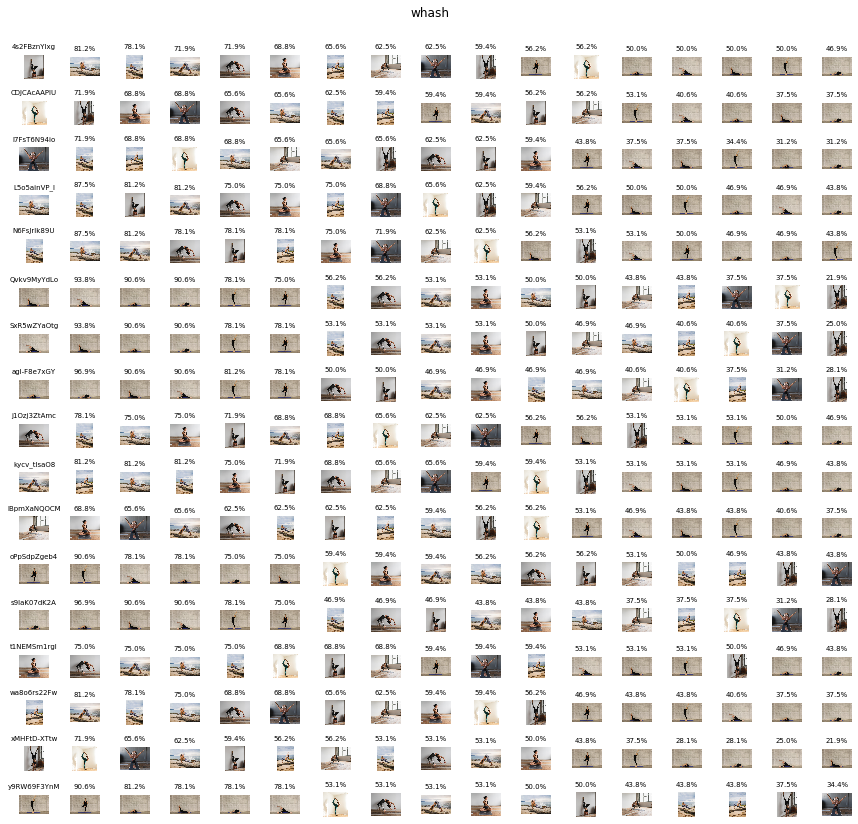

In [18]:
for hash in df_hash.columns:
    sim = 1 - hash_dist(df_hash[hash])
    df_sims = pd.concat([s_images, sim], axis=1)
    fig = plot_sims(df_sims, title=hash)
    fig.savefig(plt_path/f'matrix_{hash}.jpg', dpi=150)